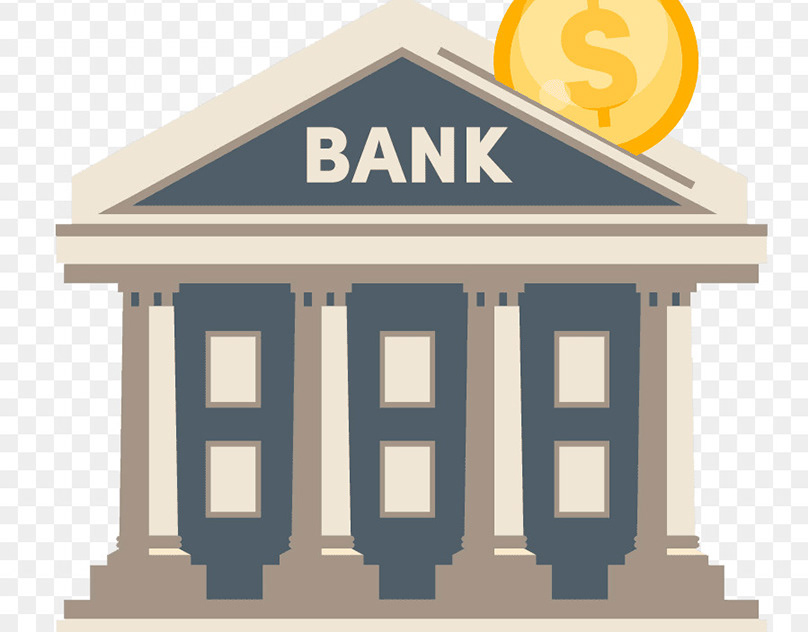

In [ ]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
!pip install category_encoders
import category_encoders as ce
!pip install plotly
import plotly
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
!pip install hyperopt
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
!pip install optuna
import optuna

%matplotlib inline
plt.style.use('seaborn')



<ipython-input-152-b40772052135>:35: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [ ]:
data = pd.read_csv('/content/bank_fin.csv', sep=';')

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
data.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Графики Выше показывают нам, что в каждом признаке есть выбросы. Это означает, что нам нужно провести работу по выявлению и удалению данных объектов из набора данных.

# **1. ПЕРВИЧНАЯ ОБРАБОТКА ДАННЫХ**

In [ ]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

balance    0.223974
dtype: float64

В признаке баланса, у нас 22 процента пропущенных значений, заполним пропущенные знаени медианой!

In [ ]:
data['balance'].mode()

0    0  $ 
Name: balance, dtype: object

In [ ]:
data['balance'] = data['balance'].str.replace(' ', '').str.replace(',', '.').str.replace('$', '').astype('float')

<ipython-input-158-b4550d4262ec>:1: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [ ]:
data['balance'] = data['balance'].fillna(data['balance'].median())

In [ ]:
data['balance'].isnull().mean() * 100

0.0

In [ ]:
data['poutcome'].value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

Данный столбец (poutcome (результат прошлой маркетинговой кампании)) как мы наблюдаем не имеет большой смыловой нагрузки для дальнейшей работы, поскольку более 8-ми тысяч объектов - это пропущенные значения. Ценность имеют только две тысячи обектов - положительный, либо отрицательный рез-тат прошлой маркетинговой кампании. Это важная информация, но ее очень мало, а заполнять остальные объектами иными значениями не даст нам положительного результата в обучении модели, а создаст только шум! Поэтому я принимаю решение - отказаться от использования данного столбца.

In [ ]:
data = data.drop('poutcome', axis=1)

In [ ]:
data['previous'].value_counts(normalize=True)

0     0.745744
1     0.079466
2     0.062086
3     0.038972
4     0.021860
5     0.014782
6     0.010482
7     0.006898
8     0.005375
9     0.003046
10    0.002688
11    0.002061
12    0.001433
13    0.000985
17    0.000985
14    0.000538
15    0.000448
19    0.000358
16    0.000179
20    0.000179
27    0.000179
23    0.000179
40    0.000090
41    0.000090
28    0.000090
18    0.000090
58    0.000090
55    0.000090
26    0.000090
21    0.000090
22    0.000090
30    0.000090
29    0.000090
37    0.000090
Name: previous, dtype: float64

Те же аргументы для столбца "previous". Это шум, который не позволит модели выявить все явные зависимости в данных, чтобы сделать верное предсказание.



In [ ]:
data = data.drop('previous', axis=1)

In [ ]:
data['default'].value_counts(normalize=True)

no     0.984949
yes    0.015051
Name: default, dtype: float64

Я принимаю решение также удалить столбец 'default'.

In [ ]:
data = data.drop('default', axis=1)

In [ ]:
# Обработаем пропуски в признаках образования и работы
data['education'] = data['education'].replace('unknown', data['education'].mode()[0])
data['job'] = data['job'].replace('unknown', data['job'].mode()[0])

Разберемся с выбросами, воспользуемся методом межквартильного размаха.

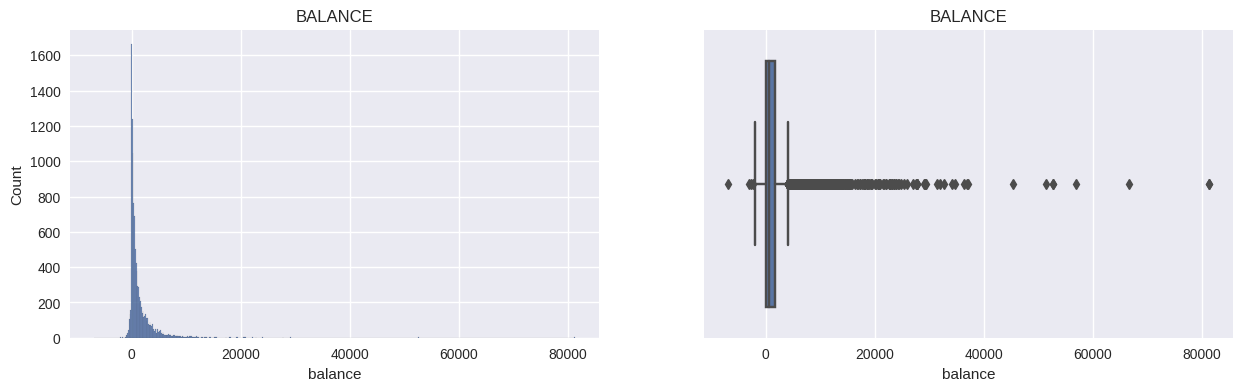

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data, x='balance', ax=axes[0]);
histplot.set_title('BALANCE');
boxplot = sns.boxplot(data=data, x='balance', ax=axes[1]);
boxplot.set_title('BALANCE');

In [ ]:
# Функция межквартильного размаха:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
  X = data[feature]
  quartile_1, quartile_3 = X.quantile(0.25), X.quantile(0.75)
  iqr = quartile_3 - quartile_1
  lower_bound = quartile_1 - (iqr * left)
  upper_bound = quartile_3 + (iqr * right)
  outliers = data[(X < lower_bound) | (X > upper_bound)]
  cleaned = data[(X > lower_bound) | (X < upper_bound)]
  return outliers, cleaned, lower_bound, upper_bound

In [ ]:
outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(data, 'balance')

In [ ]:
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Верхняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 11162
Верхняя граница: -2241.0
Нижняя граница: 4063.0


In [ ]:
# Удалим найденные в данных выбросы
data = data.drop(outliers.index, axis=0)

Таким образом, мы провели подготовку данных к разведывательному анализу и дальнейшим преобразованиям для обучения нашей модели классификации!

# **2. Разведывательный анализ данных**

In [ ]:
# Узнаем, сколько клиентов открыли депозит
data[data['deposit'] == 'yes'].count()

age          4681
job          4681
marital      4681
education    4681
balance      4681
housing      4681
loan         4681
contact      4681
day          4681
month        4681
duration     4681
campaign     4681
pdays        4681
deposit      4681
dtype: int64

In [ ]:
# Сколько сфер занятости представлено среди клиентов банка:
data['job'].nunique()

11

In [ ]:
# В каком месяце больше всего неудач по открытию депозита:
data.groupby('month')['deposit'].value_counts().unstack().sort_values('no', ascending=False)

deposit,no,yes
month,,
may,1776,841
jul,836,582
aug,775,610
jun,606,498
nov,456,324
feb,323,386
apr,317,513
jan,194,125
oct,62,273


In [ ]:
def get_category_of_age(x):
    if x < 30:
      x = '<30'
    elif x >= 30 and x < 40:
      x = '30-40'
    elif x >= 40 and x < 50:
      x = '40-50'
    elif x >= 0 and x < 60:
      x = '50-60'
    else:
      x = '60+'
    return x

In [ ]:
data['category_of_age'] = data['age'].apply(get_category_of_age)

In [ ]:
mask = data.groupby('category_of_age')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
fig = px.bar(mask,
          y  = 'yes',
          color = 'yes',
          title='Наличие депозита в зависимости от возрастной категории клиента')

fig.update_xaxes(title="Возрастная категория клиентов банка")
fig.update_yaxes(title="Количество")

#fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\EDA-DS-Projects-3\\Визуализация данных\\Grade_and_city.html")
fig.show()

Анализ графика показывает, что большинство клиентов открывают депозит в возрате от 30 до 40 лет. Примерно на одном уровне находятся категории клиентов 40-50 и <30. Меньше всего депозиты открывают люди преклонного возраста 60+.

In [ ]:
# Пронаблюдаем количество клиентов, отрывших депозит в зависимости от семейного положения
mask1 = data.groupby('marital')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
mask2 = data.groupby('marital')['deposit'].value_counts().unstack().sort_values('no', ascending=False)

marital = ['Married', 'Single', 'Divorced']

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(y=mask1['yes'], x=marital, name='Клиенты, открывшие депозит в банке'), row=1, col=1)

fig.update_xaxes(title_text="Семейное положение клиента", row=1, col=1)

fig.add_trace(go.Bar(y=mask2['no'], x=marital, name='Клиенты, отказавшиеся открыть депозит в банке'), row=1, col=2)

fig.update_xaxes(title_text="Семейное положение клиента", row=1, col=2)


fig.update_layout(title_text="Количество клиентов, открывших депозит в зависимости от семейного положения")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\marital_status.html")
fig.show()

По семейному положению, мы видим, что большинство клиентов, находящихся в браке не готовы к открытию депозита, в случае, когда когда семейное положение - холост/не замужем, люди более охотно открывают депозит. Когда же люди находятся в разводе, мы наблюдаем схожие показатели. Стоит отметить, что показатели в первых двух категория также не сильно различаются.

In [ ]:
# Проанализируем ситуацию с уровнем образования
mask1 = data.groupby('education')['deposit'].value_counts().unstack().sort_values('yes', ascending=False)
mask2 = data.groupby('education')['deposit'].value_counts().unstack().sort_values('no', ascending=False)

education = ['Secondary', 'Tertiary', 'Primary', 'Unknown']

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(y=mask1['yes'], x=education, name='Клиенты, открывшие депозит в банке'), row=1, col=1)

fig.update_xaxes(title_text="Уровень образования клиента", row=1, col=1)

fig.add_trace(go.Bar(y=mask2['no'], x=education, name='Клиенты, отказавшиеся открыть депозит в банке'), row=1, col=2)

fig.update_xaxes(title_text="Уровень образования клиента", row=1, col=2)


fig.update_layout(title_text="Количество клиентов, открывших депозит в зависимости от уровня образования")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\education_level.html")
fig.show()

Больше всего клиентов со средним уровнем образования, большая часть которой не готова к открытию депозиту, а вот ситуация у людей с высшим образованием складывается иным образом и только очень небольшое количество людей с начальным образованием склонны к открытию депозита в банке.

In [ ]:
# Построим bar-chart для просмотра зависимости сферы-занятости клиента и наличием депозита
mask1 = data.groupby('job', as_index=False)['deposit'].value_counts()

fig = px.bar(mask1,
          y='count',
          x='job',
          color ='deposit',
          title='Наличие депозита в зависимости от сферы занятости клиента')

fig.update_xaxes(title="Сфера занятости клиентов банка")
fig.update_yaxes(title="Количество клиентов")

fig.update_layout(title_text="Количество клиентов, открывших депозит в зависимости от сферы занятости")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\field_of_employment.html")
fig.show()

Больше всего клиентов банка работают в сфере менеджмента, именно эта категори рабочих больше остальных открывает депозиты в банке. На втором месте по количеству клиентов - категория 'blue-collar' или 'синие воротнички' - категори людей, которые занимаются физическим трудом и как и предполагалось большая их часть не готова к открытию депозита.


Стоит выделить категории людей, которые находятся на пенсии или в отставке 'retired', студентов, а также безработных людей, поскольку это единственные категории, где число клиентов открывших депозит превышает число отказавшихся от данной услуги.


По остальным категориям, в целом по графику видно явное доминирование категории клиентов отказавшихся от депозита.

In [ ]:
# Теплова карта корреляции семейного положения и уровня образования
deposit_yes = data[data['deposit']=='yes']
deposit_no = data[data['deposit']=='no']

mask1 = pd.pivot_table(deposit_yes, values='deposit', index='education', columns='marital', aggfunc='count')
mask2 = pd.pivot_table(deposit_no, values='deposit', index='education', columns='marital', aggfunc='count')

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Heatmap(z=mask1.values, x=mask1.index, y=mask1.columns, name='Открыли депозит в банке'), row=1, col=1)

fig.update_xaxes(title_text="Уровень образования клиента", row=1, col=1)
fig.update_yaxes(title_text="Семейное положение клиента", row=1, col=1)

fig.add_trace(go.Heatmap(z=mask2.values, x=mask2.index, y=mask2.columns, name='Отказались открыть депозит в банке'), row=1, col=2)

fig.update_xaxes(title_text="Уровень образования клиента", row=1, col=2)
fig.update_yaxes(title_text="Семейное положение клиента", row=1, col=2)


fig.update_layout(title_text="Теплова карта корреляции семейного положения и уровня образования клиентов банка")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\marital_education.html")
fig.show()

Здесь мы получили очень информативные тепловые карты, по которым мы можем проследить количество клиентов согласившихся на открытие депозита в зависимости от уровня образования и семейного положения.

Как мы видим, и том и другом случае у нас доминирует категория клиентов находящихся в браке со средним или средне-специальным образованием.

Если же у клента высшее образование, то практически вне зависимости от семейного положения, клиент скорее откроет депозит в банке, чем откажется от него. Как мы можем наблюдать, клиенты, которые в разводе или с начальным образованием не склонны к отрытию депозита.

In [ ]:
# Проанализируем зависимость целевой переменной от числового признака:
deposit_yes = data[data['deposit']=='yes']
deposit_no = data[data['deposit']=='no']

fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Box(y=data['age'], x=data['deposit'], name='Открыли депозит в банке'), row=1, col=1)

fig.update_xaxes(title_text="Наличие депозита", row=1, col=1)
fig.update_yaxes(title_text="Возраст клиента", row=1, col=1)

fig.add_trace(go.Box(y=data['balance'], x=data['deposit'], name='Отказались открыть депозит в банке'), row=1, col=2)

fig.update_xaxes(title_text="Наличие депозита", row=1, col=2)
fig.update_yaxes(title_text="Баланс клиента", row=1, col=2)


fig.add_trace(go.Box(y=data['campaign'], x=data['deposit'], name='Отказались открыть депозит в банке'), row=2, col=1)

fig.update_xaxes(title_text="Наличие депозита", row=2, col=1)
fig.update_yaxes(title_text="Количество контактов", row=2, col=1)


fig.add_trace(go.Box(y=data['duration'], x=data['deposit'], name='Отказались открыть депозит в банке'), row=2, col=2)

fig.update_xaxes(title_text="Наличие депозита", row=2, col=2)
fig.update_yaxes(title_text="Длительность контакта в сек", row=2, col=2)


fig.update_layout(title_text="Распределение целевой переменной при помощи boxplot")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\boxplots.html")
fig.show()

Сделаем выводы по каждому графику (признаку) отдельно:

  По признаку возраста, мы наблюдаем, что средний возраст большинства клиентов, с которыми был достигнут положительный результат в кампании - 38 лет. Большинство клиентов, согласившихся на депозит от 30 до 48 лет.

  Среднее значение баланса у клиентов, с которыми был достигнут положительный результат в кампании - 500 USD. Так же чем больше баланс у клиента, тем более возможно положительное решение в сторону депозита.

  Видно, что чем больше продолжительность контакта с клиентом, тем больше возможность его согласия на депозит в банке. Средняя продолжительность контакта для таких клиентов 428 секунд. Большинство клиентов, согласившихся на депозит, общались от 245 до 726 секунд.

  По количеству контактов можно сказать, что чем большее число контактов с клиентов, тем большая веротность получения его отказа от открытия банковского депозита.

In [ ]:
# Распределение целевой переменной:

fig = px.histogram(data_frame=data,
             title='Соотношение количества клиентов, открывших депозит и отказавшихся от услуги',
             x='deposit',
             color='deposit',
             width=1000,
             height=700
             )

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\сustomer_category_ratio.html")

fig.show()

Клиентов с отрицательным исходом больше на 800, чем клиентов с положительным результатом кампании, но так как у нас достаточное количество выборок, данное различие будет не критичным.

# **3. ОТБОР И ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ**

In [ ]:
# Закодируем целевую переменную
data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Закодируем категориальные переменные
encoder = preprocessing.LabelEncoder()
data['education'] = encoder.fit_transform(data['education'])
data['category_of_age'] = encoder.fit_transform(data['category_of_age'])

In [ ]:
data['loan'].value_counts()

no     8712
yes    1393
Name: loan, dtype: int64

In [ ]:
data['housing'].value_counts()

no     5243
yes    4862
Name: housing, dtype: int64

In [ ]:
data['loan'] = data['loan'].apply(lambda x: 1 if x == 'yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Преобразование номинальных переменных, с помощью метода pd.get_dummies
df = pd.get_dummies(data[['job', 'marital', 'contact', 'month']])
data = pd.concat([data, df], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int64  
 4   balance            10105 non-null  float64
 5   housing            10105 non-null  int64  
 6   loan               10105 non-null  int64  
 7   contact            10105 non-null  object 
 8   day                10105 non-null  int64  
 9   month              10105 non-null  object 
 10  duration           10105 non-null  int64  
 11  campaign           10105 non-null  int64  
 12  pdays              10105 non-null  int64  
 13  deposit            10105 non-null  int64  
 14  category_of_age    10105 non-null  int64  
 15  job_admin.         10105 non-null  uint8  
 16  job_blue-collar    101

In [ ]:
data = data.drop(['job', 'marital', 'contact', 'month'], axis=1)

In [ ]:
data.head()

,age,education,balance,housing,loan,day,duration,campaign,pdays,deposit,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,59,1,2343.0,1,0,5,1042,1,-1,1,...,0,0,0,0,0,0,1,0,0,0
1,56,1,45.0,0,0,5,1467,1,-1,1,...,0,0,0,0,0,0,1,0,0,0
2,41,1,1270.0,1,0,5,1389,1,-1,1,...,0,0,0,0,0,0,1,0,0,0
3,55,1,2476.0,1,0,5,579,1,-1,1,...,0,0,0,0,0,0,1,0,0,0
4,54,2,184.0,0,0,5,673,2,-1,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
#Построим тепловую карту корреляций признаков
corrs = data.corr()

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z= corrs.values,
    x= corrs.columns,
    y= corrs.index,
    ))

fig.update_layout(
    title="Тепловая карта признаков",
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="lightsteelblue",
)

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\Heatmap_of_Features.html")

fig.show()

По данной тепловой карте, мы можем наблюдать мультиколлинеарность только у нескольких признаков - [contact_cellular / contact_unknown], [marital_single / marital_married] - эта мульколлинеарность является логичной т.к. признаки взаимоисключающие друг друга.

Теперь нам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

In [ ]:
y = data['deposit']
X = data.drop(['deposit'], axis=1)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в нашей задаче классификации
feature_function = SelectKBest(score_func=f_classif, k=15)
feature_function.fit(X_train, y_train)

selected_cols = feature_function.get_feature_names_out()

print(f'Признаки для обучения модели машинного обучения: {selected_cols}')

X_train = feature_function.transform(X_train)
X_test = feature_function.transform(X_test)

Признаки для обучения модели машинного обучения: ['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays'
 'category_of_age' 'job_student' 'contact_cellular' 'contact_unknown'
 'month_apr' 'month_mar' 'month_may' 'month_oct' 'month_sep']


Таким образом, с помощью метода SelectKBest мы избавились от лишнего шума в данных. Теперь модель легче усвоит явные взаимосвязи в данных, но для того, чтобы показания метрики значительно улучшились, нам необходимо нормализовать данные.

In [ ]:
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)

X_test = mm_scaler.fit_transform(X_test)

In [ ]:
#Для нормализации воспользуемся методом MinMaxScaler()
mm_scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(data=mm_scaler.fit_transform(X_train), columns=['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
 'category_of_age', 'job_student', 'contact_cellular', 'contact_unknown',
 'month_apr', 'month_mar', 'month_may', 'month_oct', 'month_sep'])

X_test = pd.DataFrame(data=mm_scaler.fit_transform(X_test), columns=['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
 'category_of_age', 'job_student', 'contact_cellular', 'contact_unknown',
 'month_apr', 'month_mar', 'month_may', 'month_oct', 'month_sep'])

In [ ]:
display(X_train)

,balance,housing,loan,duration,campaign,pdays,category_of_age,job_student,contact_cellular,contact_unknown,month_apr,month_mar,month_may,month_oct,month_sep
0,0.426374,1.0,0.0,0.131735,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.346531,0.0,1.0,0.075793,0.000000,0.240936,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.335242,1.0,0.0,0.102346,0.023810,0.419883,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.407886,0.0,0.0,0.034803,0.000000,0.120468,0.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.571499,0.0,0.0,0.025264,0.000000,0.138012,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765,0.371564,0.0,1.0,0.028100,0.000000,0.239766,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6766,0.625982,1.0,0.0,0.204692,0.095238,0.181287,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6767,0.879090,0.0,0.0,0.030936,0.000000,0.108772,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6768,0.369437,0.0,0.0,0.155452,0.023810,0.000000,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. РЕШЕНИЕ ЗАДАЧИ КЛАССИФИКАЦИИ: ЛОГИСТИЧЕСКА РЕГРЕССИЯ И РЕШАЮЩИЕ ДЕРЕВЬЯ**

## **4.1 Логистическая регрессия**

In [ ]:
#Обучим простой алгоритм логистической регрессии
model_lr = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000
)

In [ ]:
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [ ]:
y_pred_train = model_lr.predict(X_train)

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
print(f'f1-score на обучающей выборке: {metrics.f1_score(y_train, y_pred_train)}')
print(f'f1-score на тестовой выборке: {metrics.f1_score(y_test, y_pred)}')

f1-score на обучающей выборке: 0.7958012137116615
f1-score на тестовой выборке: 0.7974803149606299


Простая модель логистической регрессии справляется в задачей классификацией в более чем 80% случаев. Для такой простой модели, без оптимизации, - это отличные показатели метрики f1-score.

# **4.2 Дерево решений**

In [ ]:
model_dt = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = 42
)

In [ ]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
y_pred_train = model_dt.predict(X_train)

In [ ]:
y_pred = model_dt.predict(X_test)

In [ ]:
print(f'f1-score на обучающей выборке: {metrics.f1_score(y_train, y_pred_train)}')
print(f'f1-score на тестовой выборке: {metrics.f1_score(y_test, y_pred)}')

f1-score на обучающей выборке: 1.0
f1-score на тестовой выборке: 0.745


В данном случае, мы наблюдаем переобучение модели, когда модель подстраивается под обучающий набор данных.

Подберем параметр максимальной глубины дерева.

In [ ]:
train_scores = []
test_scores = []
for max_depth in range(1,20):
    model_dt = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=max_depth)
    model_dt.fit(X_train, y_train)
    y_pred_train = model_dt.predict(X_train)
    y_pred_test = model_dt.predict(X_test)
    train_scores.append(metrics.accuracy_score(y_train, y_pred_train))
    test_scores.append(metrics.accuracy_score(y_test, y_pred_test))

In [ ]:
max_depth = list(range(1,20))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_scores, x=max_depth, name='train_score'))
fig.add_trace(go.Scatter(y=test_scores, x=max_depth, name='test_score'))

fig.update_xaxes(title_text="Глубина дерева")
fig.update_yaxes(title_text="f1-score")

fig.write_html("C:\\Users\\Admin\\Documents\\GitHub\\SF_DataSciense\\ML-DS-Project-4\\Визуализация данных\\selection_of_parameters.html")

fig.show()

На тестовой выборке, максимум качества мы достигаем при условии глубины дерева в 7 вершин.

In [ ]:
model_dt = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = 42,
    max_depth=7
)

In [ ]:
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

In [ ]:
y_pred_train = model_dt.predict(X_train)
y_pred = model_dt.predict(X_test)
print(f'f1-score на обучающей выборке: {metrics.f1_score(y_train, y_pred_train)}')
print(f'f1-score на тестовой выборке: {metrics.f1_score(y_test, y_pred)}')

f1-score на обучающей выборке: 0.8169871794871795
f1-score на тестовой выборке: 0.8071253071253072


Модель дерева решений также склонна к переобучению. Чтобы это исправить попробуем воспользоваться методом GridSearchCV для оптимизации гиперпараметров модели:

In [ ]:
# Реализуем оптимизацию гиперпараметров с помощью метода GridSearch
param_grid={
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7, 8, 9]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = 42),

    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 9],
                         'min_samples_split': [2, 5, 7, 10]})

In [ ]:
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

In [ ]:
print(f'f1-score на обучающей выборке: {metrics.f1_score(y_train, y_pred_train)}')
print(f'f1-score на тестовой выборке: {metrics.f1_score(y_test, y_pred_test)}')
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1-score на обучающей выборке: 0.8167975637121334
f1-score на тестовой выборке: 0.8071253071253072
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


Найдя оптимальные параметры регуляризации дерева решения, мы наблюдаем, что показатель тестовой метрики стал даже больше, чем на тренирововчной выборке.

В свою очередь, это означает, что модель подстраивается под обучающую выборку. Она была чрезмерно натренерована на обнаружение уникальных характерикстик обучающего набора данных, которые не являются общими закономерностями.

Попробуем решить проблему переобучения модели методом ансамблирования!

# **5. РЕШЕНИЕ ЗАДАЧИ КЛАССИФИКАЦИИ: АНСАМБЛИ МОДЕЛЕЙ И ПОСТРОЕНИЕ ПРОГНОЗА**

# **5.1 Случайный лес**

In [ ]:
#Построение и обучение случайного леса
RandomForest = ensemble.RandomForestClassifier(
                                                n_estimators=100,
                                                criterion='gini',
                                                min_samples_leaf=5,
                                                max_depth=10,
                                                random_state=42)
RandomForest.fit(X_train, y_train)
y_pred_train = RandomForest.predict(X_train)
y_pred_test = RandomForest.predict(X_test)

print('Обучающая выборка:\n{}'.format(metrics.classification_report(y_train, y_pred_train)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3634
           1       0.83      0.88      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770



In [ ]:
print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1790
           1       0.76      0.90      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.83      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335



Мы видим, что использование случайного леса помогло избавиться от переобучения. Показатели метрик стали различаться, а это означает, что мы идем в правильном направлении. Посмотрим, что будет если мы обучим алгоритм градиентного бустинга.

# **5.2 Градиентный бустинг**

In [ ]:
# Построение и обучение градиентного бустинга
gb = ensemble.GradientBoostingClassifier(
                                        learning_rate=0.05,
                                        n_estimators=300,
                                        min_samples_leaf=5,
                                        max_depth=5,
                                        random_state=42
                                        )
gb.fit(X_train, y_train)

y_pred_train = gb.predict(X_train)
y_pred_test = gb.predict(X_test)

# Признаки демонстрирующие наибольшую  важность в модели градиентного бустинга
sorted(list(zip(selected_cols, gb.feature_importances_)), key=lambda x: x[1], reverse=True)

[('duration', 0.5112960821270878),
 ('pdays', 0.11920103798389176),
 ('contact_unknown', 0.0732291130005701),
 ('balance', 0.06397241274656935),
 ('housing', 0.05549946318738152),
 ('category_of_age', 0.04270824322085987),
 ('month_mar', 0.027197861530571476),
 ('month_oct', 0.021201881777828616),
 ('month_apr', 0.01849673226568759),
 ('month_may', 0.017881991232475726),
 ('month_sep', 0.016523671871901645),
 ('campaign', 0.014804814707403363),
 ('loan', 0.010838563409816954),
 ('contact_cellular', 0.005333639702329831),
 ('job_student', 0.0018144912356243843)]

In [ ]:
print('Обучающая выборка:\n{}'.format(metrics.classification_report(y_train, y_pred_train)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3634
           1       0.87      0.90      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770



In [ ]:
print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1790
           1       0.76      0.89      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.83      0.83      0.82      3335
weighted avg       0.83      0.82      0.82      3335



Здесь на тесте все также как и в случае случайного леса, но на тренировочной выборке алгоритм градиентного бустинга смог уловить больше закономерностей, чем алгоритм случайного леса.

# **5.3 Стекинг**

In [ ]:
# Используем стекинг, объединив те алгоритмы, которые уже использовали ранее

estimators = [('dtree', model_dt), ('logreg', model_lr), ('gridboost', gb)]

stacking = ensemble.StackingClassifier(estimators=estimators)

stacking.fit(X_train, y_train)

y_pred_train = stacking.predict(X_train)

y_pred_test = stacking.predict(X_test)

print('Обучающая выборка:\n{}'.format(metrics.classification_report(y_train, y_pred_train)))

Обучающая выборка:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      3634
           1       0.86      0.87      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770



In [ ]:
print('Тестовая выборка:\n{}'.format(metrics.classification_report(y_test, y_pred_test)))

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1790
           1       0.77      0.89      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



А вот с помощью стекинга мы сумели улучшить метрику на тестовом наборе данных, но стекинг лишь немного улучшил метрики по сравнению с простыми решениями.

Таким образом, мы обучили множество разных моделей, с разными параметрами. Применили методы отимизации гиперпараметров, была проведена предобработка данных, найдены и заполнены пропуски, найдены и удалены выбросы в данных.
Проведен разведывательный анализ данных, кодирование данных, нормализация признаков, отбор признаков.

Можно попробовать улучшить качество предсказания, используя более продвинутые подходы для удаления выбросов или беря больше признаков. Так же можно создать бόльшую сетку параметров для отбора оптимизацией или использовать новые алгоритмы.